#  Hw 3 Principal Component Analysis

In [3]:
import os
from time import time
import pandas as pd
import numpy as np
from skimage import io
from matplotlib import pyplot as plt
from skimage.transform import rescale
import matplotlib.cm as cm
import cv2

Lets define a function that can import and image as grey, and then rescale the image to downsize it by 3.0 times the orignal size. This will help us with our calculation of the covariant matrix to find the eigenvectors later.

Import the images by using the list directory from the yaleface folder.

In [5]:

def readFaceImages(imdir, ext="png"):
    # imdir: e.g. "hw5_supplemental/faces/"
    # return
    # im    : 2D np.ndarray of images
    # person: np.ndarray of person_id
    # number: np.ndarray of number (lighting condition)
    # subset: np.ndarray of subset_idx
    names = list_files_walk_subdirs(imdir, ext)
    im = []
    person = []
    number = []
    subset = []
    shape = []
    for name in names:
        idx2 = name.split('/')[-1][6:-4].split('_')
        person.append(int(name.split('person')[1].split('_')[0]))
        number.append(int(idx2[1]))
        image = cv2.imread(name)[:, :, 0]
        im.append(image)
        if number[-1] <= 7:
            subset.append(1)
        elif number[-1] <= 19:
            subset.append(2)
        elif number[-1] <= 31:
            subset.append(3)
        elif number[-1] <= 45:
            subset.append(4)
        elif number[-1] <= 64:
            subset.append(5)
    return np.array(im), np.array(person), np.array(number), np.array(subset), np.array(shape)

def list_files_walk_subdirs(path, exts):
    if isinstance(exts, str):
        exts = [exts]
    return [os.path.join(pt, name) for pt, dirs, files in os.walk(path) for name in files if name.lower().split('.')[-1] in exts and (not name.split('/')[-1].startswith('.'))]



In [6]:
images, people, numbers, subsets, shape = readFaceImages('/yalefaces/faces', "png")

imagesAnalyze =  np.zeros([5, 50, 50])
imagesAnalyze[0]=(images[0])  
imagesAnalyze[1]=(images[7])
imagesAnalyze[2]=(images[19])  
imagesAnalyze[3]=(images[31])   
imagesAnalyze[4]=(images[45])      

We now normalize the data by dividing the entries by the mean

### Lets compute the covariance matrix. I used the slided from **class** which say 

$$ S =  \frac{1}{N} X^T X $$

which gives us a dimensionality of: **{DxD}**

In [7]:
X = None
data_1d = images.reshape([images.shape[0], -1])
data_mean = data_1d.mean(0)
X = data_1d - data_mean
S = np.dot(X.T,X)/(X.shape[0]-1)

In [8]:
eigenvalues,eigenvectors =  np.linalg.eigh(S)  #lets find the eigenvalues and vectors

In [33]:
eigenvalues = eigenvalues[::-1]

eigenfaces = []
for i in range(640):
    UT =  eigenvectors.T[i]
    temp = UT.real
    temp = temp.reshape([50,50])
    eigenfaces.append(temp)
eigenvectors = eigenvectors[:, ::-1]  #orders the eignevtors as columns

We have obtained 2500 eigenvalues


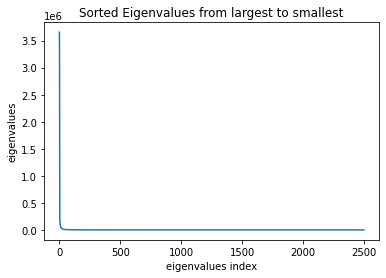

In [10]:
print("We have obtained", len(eigenvalues), "eigenvalues")
plt.plot(eigenvalues)
plt.xlabel("eigenvalues index")
plt.ylabel("eigenvalues")
plt.title("Sorted Eigenvalues from largest to smallest")
plt.show()
Uvector =  eigenvectors[:,0:9]   #take the first nine 
Ueigen = eigenvalues[0:9]     #take the corresponding eigenvectors

# Top 9 Eigenfaces

### From the computed eignevectors, we can extract the eigenfaces.

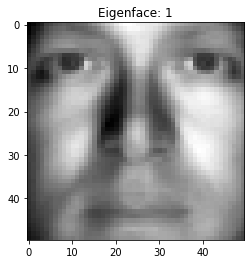

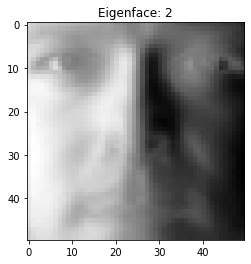

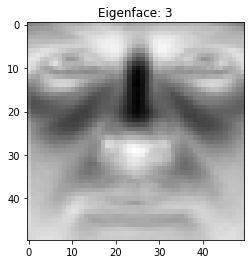

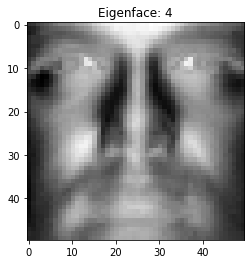

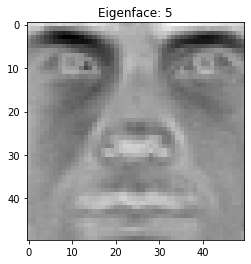

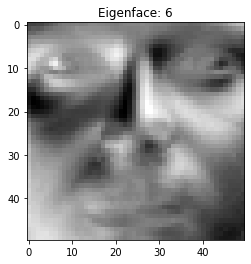

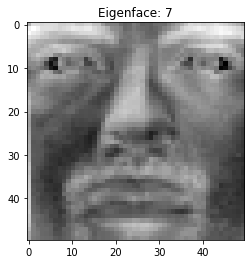

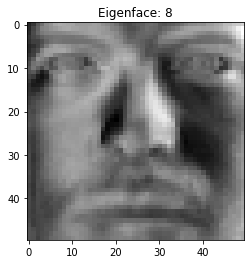

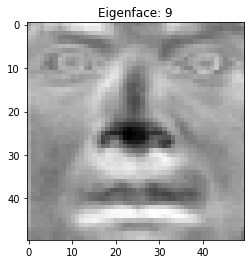

In [24]:


for i in range(9):
    UT =  Uvector.T[i]
    temp = UT.real
    temp = temp.reshape([50,50])
    plt.imshow(temp, cmap = cm.gray)
    plt.title("Eigenface: "+str(i+1))
    plt.show()


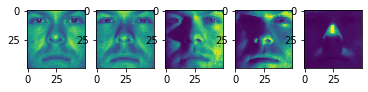

In [13]:
for i in range(5):
    plt.subplot(2, 5, i+1)
    plt.title("Original Eigenfaces")
    plt.imshow(imagesAnalyze[i])

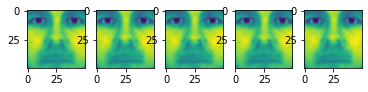

In [42]:

projected = (imagesAnalyze.reshape([5, -1]) - data_mean) @ eigenvectors[:, :9]
unprojected = projected @ eigenvectors[:, :9].T + data_mean
unprojected = unprojected.reshape([5, 50, 50])

for i in range(5):
    plt.subplot(2, 5, i+1)
    plt.imshow(unprojected[i])

## Face Recognition

I will try to identify the subject based on the recation. By splitting the data into training and testing I can then train a Support Vector Machine to identify the correct subject number from the training set images.

In [63]:
import scipy.misc as im

def load_subset(subset, size):
    data = []
    label = []
    i = 0
    for image in range(len(images)):
        if(subsets[image]==subset):
            face = np.array(images[image]).flatten()
            data.append(face)
            label.append( people[image])
            i= i+1
    
    return data, label

In [64]:
train_data,train_labels = load_subset(1, 70)
test1_data,test1_labels = load_subset(2, 120) 
test2_data,test2_labels = load_subset(3,120) 
test3_data,test3_labels = load_subset(4, 140) 
test4_data,test4_labels = load_subset(5, 190)
test_data_list = [test1_data, test2_data, test3_data, test4_data]
test_labels_list = [test1_labels, test2_labels, test3_labels, test4_labels]


In [71]:
def k_nearest_neighbors(img, train_set, train_labels, k, o, eigen):
    
    #list parallel to test_set containing euclidean distance info
    euclidian = []
    #print('test im: ', img)

    #compute l2 norm between input image and all images in test set
    for train_img in train_set:
        if eigen == False:
            euclidian.append(np.linalg.norm(np.reshape(img, (1, 2500)) - np.reshape(train_img, (1, 2500)) ,ord=o))
        elif eigen == True:
            #print('train im: ', train_img)
            euclidian.append(np.linalg.norm(np.asarray(img) - np.asarray(train_img) ,ord=o))
#             print('norm: ', np.linalg.norm(img - train_img, ord=2))
#             print()

    #make a new data structure so we can sort for top k items:
    pairs = [[train_labels[i], euclidian[i], train_set[i], i] for i in range(len(train_labels))]

    p = sorted(pairs, key=lambda x: x[1])
    
    #get the k predictions for lowest l2 norms
    k_predictions = [p[i][0] for i in range(k)]
#     print(k_predictions)
    
    #prediction we want to return is the mode of k_predictions
    counter = np.bincount(np.asarray(k_predictions))
    
    if k > 1:
        return np.argmax(counter)
    elif k == 1 and eigen == True:
        return np.argmax(counter)
    else:
        return np.argmax(counter), p[0][2]


In [120]:
def eigenTrain(train, k):
    
    #make a matrix of vectorized training images:
    vectorized_data = [np.reshape(train_img, (1, 2500))[0] for train_img in train]
    vdt = np.transpose(vectorized_data)
    
    
    #compute the mean for each column of the vectorized_data matrix
    vec_means = []
    for row in vdt:
        vec_means.append(np.mean(row))
    
    #subtract each cell in vectorized_data matrix by the global mean:
    for i in range(len(vectorized_data)):
        for j in range(len(vectorized_data[i])):
            vectorized_data[i][j] = copy.deepcopy(vectorized_data[i][j]) - vec_means[j]
        
    #perform singular value decomposition on vectorized data matrix:
    u, s, v_trans = np.linalg.svd(vectorized_data, full_matrices=True)
    
    #get top k rows of v:
    top_k = v_trans[:k]
    
    return top_k, vec_means, np.transpose(vectorized_data)

def test_eig(test_data, test_labels, train_data, train_labels):
    
    #call eigen train:
    eig_vecs, eig_avs, vdt = eigenTrain(train_data, 2500)
    test_accuracy = [[0 for i in range(30)]for j in range(4)]
    for i in range(len(test_data)):
        test_set = test_data[i]
        for k in [9,30]:
       
            
            eigs = np.transpose(eig_vecs)[:k]
            #eigs = np.transpose(eig_vecs)[5:k]
            k_train = []
            
            #get training images in k dimensions
            for j in range(len(train_data)):
                
                vec = np.reshape(train_data[j], (1, 2500)) - eig_avs
                vec = np.transpose(vec)
                k_train.append(np.matmul(eigs,vec))
            
            #get k dimensional representation of test image
            for j in range(len(test_set)):
                
                vec = np.reshape(test_set[j], (1, 2500)) - eig_avs
                vec = np.transpose(vec)
                k_img = np.matmul(eigs,vec)
                
                #nearest neighbor prediction
                prediction = k_nearest_neighbors(k_img, k_train, train_labels, k=1, o=2, eigen=True)
                
                if prediction == test_labels[i][j]:
                    test_accuracy[i][k-1] += 1
                    #test_accuracy[i][k-6] += 1
        
    return test_accuracy
    

In [121]:
import copy
import texttable
sa = test_eig(test_data_list, test_labels_list, train_data, train_labels)

t = texttable.Texttable()
t.add_rows([['error','2', '3', '4', '5'], ['error% k = 9', str(1-sa[0][8]/120), str(1-sa[1][8]/120), str(1-sa[2][8]/140), str(1-sa[3][8]/190)], ['error% k = 30', str(1-sa[0][29]/120), str(1-sa[1][29]/120), str(1-sa[2][29]/140), str(1-sa[3][29]/190)]])
print(t.draw())
    #plot things
   

+---------------+-------+-------+-------+-------+
|     error     |   2   |   3   |   4   |   5   |
+===============+=======+=======+=======+=======+
| error% k = 9  | 0.958 | 0.917 | 0.907 | 0.905 |
+---------------+-------+-------+-------+-------+
| error% k = 30 | 1     | 0.942 | 0.936 | 0.911 |
+---------------+-------+-------+-------+-------+


Part 2- Scene Categorization

In [134]:
from sklearn.cluster import KMeans
from sklearn import preprocessing
import glob

In [128]:
train_data = np.load('C:\\arrays/train_D.npy', allow_pickle= True)
train_label =  np.load('C:\\arrays/train_gs.npy', allow_pickle= True)
test_data =  np.load('C:\\arrays/test_D.npy', allow_pickle= True)
test_label = np.load('C:\\arrays/test_gs.npy', allow_pickle= True)


train_num = len(train_label)

test_num = len(test_label)

In [136]:
from sklearn.neighbors import KNeighborsClassifier

# train model
def trainKNN(data, labels, k):
    neigh = KNeighborsClassifier(n_neighbors=k, p=2)
    neigh.fit(data, labels) 
    return neigh

In [130]:
def computeSIFT(data):
    x = []
    for i in range(0, len(data)):
        sift = cv2.SIFT_create()
        img = data[i]
        step_size = 15
        kp = [cv2.KeyPoint(x, y, step_size) for x in range(0, img.shape[0], step_size) for y in range(0, img.shape[1], step_size)]
        dense_feat = sift.compute(img, kp)
        x.append(dense_feat[1])
        
    return x

# extract dense sift features from training images
x_train = computeSIFT(train_data)
x_test = computeSIFT(test_data)

all_train_desc = []
for i in range(len(x_train)):
    for j in range(x_train[i].shape[0]):
        all_train_desc.append(x_train[i][j,:])

all_train_desc = np.array(all_train_desc)

In [131]:
def clusterFeatures(all_train_desc, k):
    kmeans = KMeans(n_clusters=k, random_state=0).fit(all_train_desc)
    return kmeans

In [138]:
def formTrainingSetHistogram(x_train, kmeans, k):
    train_hist = []
    for i in range(len(x_train)):
        data = copy.deepcopy(x_train[i])
        predict = kmeans.predict(data)
        train_hist.append(np.bincount(predict, minlength=k).reshape(1,-1).ravel())
        
    return np.array(train_hist)


# build histograms for test set and predict
def predictKMeans(kmeans, scaler, x_test, train_hist, train_label, k):
    # form histograms for test set as test data
    test_hist = formTrainingSetHistogram(x_test, kmeans, k)
    
    # make testing histograms zero mean and unit variance
    test_hist = scaler.transform(test_hist)
    
    # Train model using KNN
    knn = trainKNN(train_hist, train_label[0], k)
    predict = knn.predict(test_hist)
    return np.array([predict], dtype=np.array([test_label]).dtype)
    

def accuracy(predict_label, test_label):
    return np.mean(np.array(predict_label.tolist()[0]) == np.array(test_label))

In [139]:
k = [10, 15, 20, 25, 30, 35, 40]
for i in range(len(k)):
    kmeans = clusterFeatures(all_train_desc, k[i])
    train_hist = formTrainingSetHistogram(x_train, kmeans, k[i])
    
    # preprocess training histograms
    scaler = preprocessing.StandardScaler().fit(train_hist)
    train_hist = scaler.transform(train_hist)
    
    predict = predictKMeans(kmeans, scaler, x_test, train_hist, train_label, k[i])
    res = accuracy(predict, test_label)
    print("k =", k[i], ", Accuracy:", res*100, "%")

k = 10 , Accuracy: 20.375 %
k = 15 , Accuracy: 21.0 %
k = 20 , Accuracy: 27.250000000000004 %
k = 25 , Accuracy: 27.750000000000004 %
k = 30 , Accuracy: 27.625 %
k = 35 , Accuracy: 28.999999999999996 %
k = 40 , Accuracy: 29.125 %


Design Decisions
KMeans and BoW- in the Bag of Words representation, I chose a step size of 15 for my key points and extracted features using a SIFT algorithm. My KMeans stopping criterion is The distance of datapoints from their centroid is minimum ( the min length is k) because it is less time consuming than other methods

Histogram and Classifier- I chose to represent 7 different kmeans clusters- 10 through 30 with an interval of five. I chose these because as K rises, accuracy increases, but, as shown above, there was clear leveling of the accuracy around 30% when K grew past 30. Using K=10 through K=40, I showed both the data and the trend of the data. 

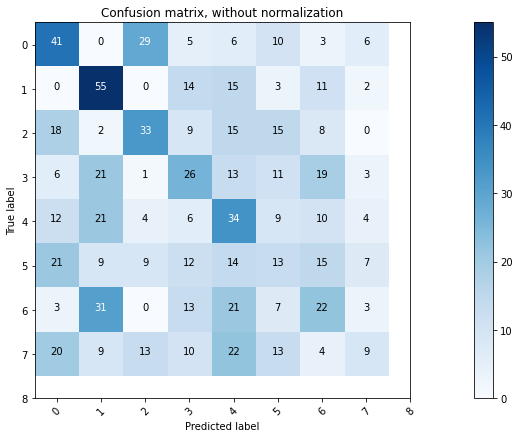

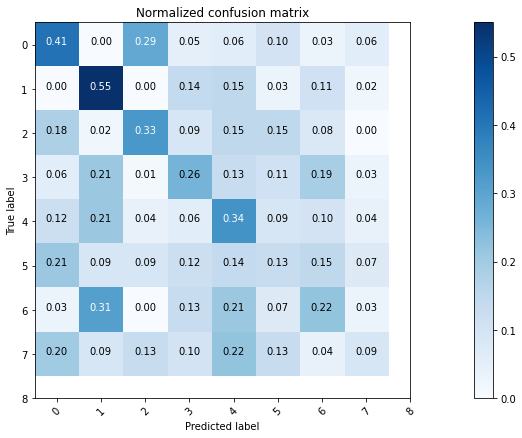

In [148]:
import itertools
from sklearn.metrics import confusion_matrix

class_names = {0,1,2,3,4,5,6,7,8}
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        #print("Normalized confusion matrix")

    #print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Compute confusion matrix
cnf_matrix = confusion_matrix(np.array(test_label[0]).T, np.array(predict[0]) )#input res
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure(figsize=(18, 6))
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure(figsize=(18, 6))
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()